<a href="https://colab.research.google.com/github/olegkleiman/tf2/blob/master/nonlinear_regression_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Non-linear regression based with Keras and TensorFlow TPU for [BoxBOD](https://www.itl.nist.gov/div898/strd/nls/data/boxbod.shtml) MNIST dataset 

In [74]:
!pip install -U pip install -U tensorboard_plugin_profile==2.3.0

     |████████████████████████████████| 1.5MB 6.8MB/s 
     |████████████████████████████████| 1.1MB 13.2MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


Initialize TensorFlow and check the local devices

In [82]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.python.client import device_lib
import os

print("TF version: {}".format(tf.__version__))
print("Local device: ", device_lib.list_local_devices())

TF version: 2.4.1
Local device:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10817345899506669480
]


Now switch to TPU System

In [80]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

tpu_strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.82.5.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.5.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Prepare the data

In [78]:
DATASET_SIZE = 100
x = tf.random.uniform(shape=(DATASET_SIZE,), minval=0., maxval=1.0) * 10
perturb = tf.random.normal(shape=(len(x), ), stddev=0.01)
beta1 = 1.1
beta2 = 1.1

y = beta1 * (1 - tf.exp(-beta2 * x)) + perturb

train_size = int(0.7 * DATASET_SIZE)

# TODO: split into train and test sub-sets
x_train = x
y_train = y
# y_train = y[:, 1:2]

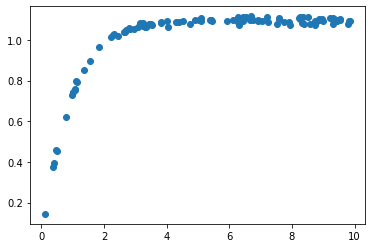

In [79]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x_train, y_train)
plt.show()



## Prepare and train the model

In [81]:
from tensorflow import keras
import datetime as datetime

class KerasModel(tf.keras.Model):
  def __init__(self):
    super(KerasModel, self).__init__()
    self.dense1 = keras.layers.Dense(50, input_dim=1, activation=tf.nn.relu)
    self.dense2 = keras.layers.Dense(100, kernel_initializer="glorot_uniform", activation=tf.nn.relu)
    self.dense3 = keras.layers.Dense(1, kernel_initializer="glorot_uniform", activation=None)

  def call(self, inputs):
    x = self.dense1(inputs)
    x = self.dense2(x)
    return self.dense3(x)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', 
                                                        min_delta=1.2e-4,
                                                        patience=6, 
                                                        verbose=True)
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = KerasModel()
  model.compile(loss=keras.losses.mean_squared_error,
                steps_per_execution = 50,
                optimizer=keras.optimizers.Adam())
  model.fit(x_train, y_train, 
            epochs=1000, 
            batch_size=100,
            verbose=True,
            callbacks=[early_stopping_callback])
model.summary()

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 6.4219
Epoch 2/1000
1/1 [==============================] - 0s 17ms/step - loss: 5.3490
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 4.3970
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 3.5693
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 2.8319
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 2.1991
Epoch 7/1000
1/1 [==============================] - 0s 18ms/step - loss: 1.6687
Epoch 8/1000
1/1 [==============================] - 0s 19ms/step - loss: 1.2257
Epoch 9/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.8667
Epoch 10/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.5863
Epoch 11/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.3785
Epoch 12/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.2393
Epoch 13/1000
1/1 [====================

Make the predictions and show the chart visualization

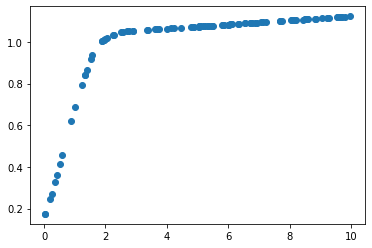

In [70]:
y_predicted = model.predict(x_train)

plt.scatter(x_train, y_predicted)